# **Name: Aditya Mishra | Roll Number: 21013 | Computer Vision Assignment-3**

## **Connecting to the Assignment Directory**

In [46]:
%cd /content/drive/MyDrive/Computer Vision/Assignment-3

/content/drive/MyDrive/Computer Vision/Assignment-3


## **Question-01**

## **Converting to Gray Scale**

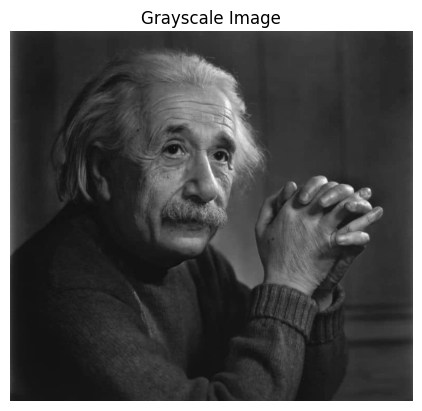

(706, 768)

In [47]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.feature import hog as computes_hog
from skimage.color import rgb2gray

# Load the image (provided as image.jpg by the user)
image_path = 'image.jpg'
image = imread(image_path)

# Convert to grayscale for processing
gray_image = rgb2gray(image)

# Display the grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

gray_image.shape

## **Scale-Invariant Feature Transform (SIFT)**

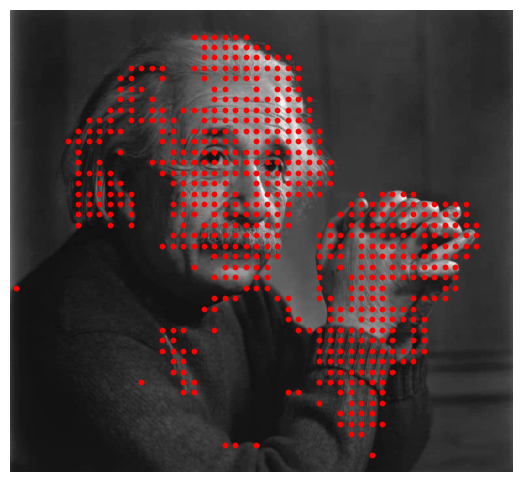

(591, 591)

In [48]:
def detect_keypoints_and_descriptors(image, window_size=16):
    """
    Simplified implementation of SIFT (Scale-Invariant Feature Transform).
    Detects key points and computes descriptors for grayscale images.

    Args:
        image (numpy.ndarray): Grayscale image.
        window_size (int): Size of the window to compute descriptors.

    Returns:
        keypoints (list): List of keypoint coordinates [(x, y), ...].
        descriptors (list): List of descriptors corresponding to the keypoints.
    """
    height, width = image.shape
    keypoints = []
    descriptors = []

    # Compute gradients (Ix, Iy)
    Ix = np.zeros_like(image)
    Iy = np.zeros_like(image)
    Ix[:, 1:-1] = image[:, 2:] - image[:, :-2]
    Iy[1:-1, :] = image[2:, :] - image[:-2, :]

    # Compute magnitude and orientation of gradients
    magnitude = np.sqrt(Ix**2 + Iy**2)
    orientation = np.arctan2(Iy, Ix) * (180 / np.pi) % 360  # Orientation in degrees

    # Detect keypoints (e.g., by thresholding magnitude)
    threshold = magnitude.mean() + magnitude.std() * 2
    for y in range(window_size // 2, height - window_size // 2, window_size):
        for x in range(window_size // 2, width - window_size // 2, window_size):
            window_magnitude = magnitude[y - window_size // 2: y + window_size // 2,
                                         x - window_size // 2: x + window_size // 2]
            max_val = np.max(window_magnitude)
            if max_val > threshold:
                keypoints.append((x, y))

                # Compute descriptor as a histogram of orientations
                window_orientation = orientation[y - window_size // 2: y + window_size // 2,
                                                  x - window_size // 2: x + window_size // 2]
                descriptor, _ = np.histogram(window_orientation, bins=8, range=(0, 360),
                                             weights=window_magnitude)
                descriptors.append(descriptor / np.linalg.norm(descriptor))  # Normalize

    return keypoints, descriptors

# Apply SIFT to the grayscale image
sift_keypoints, sift_descriptors = detect_keypoints_and_descriptors(gray_image)

# Visualize the detected keypoints on the image
plt.figure(figsize=(8,6))
plt.imshow(gray_image, cmap='gray')
plt.scatter([kp[0] for kp in sift_keypoints], [kp[1] for kp in sift_keypoints], c='r', s=10)
#plt.title('Keypoints Detected by SIFT')
plt.axis('off')
plt.show()

len(sift_keypoints), len(sift_descriptors)

## **Bag of Words (BoW)**

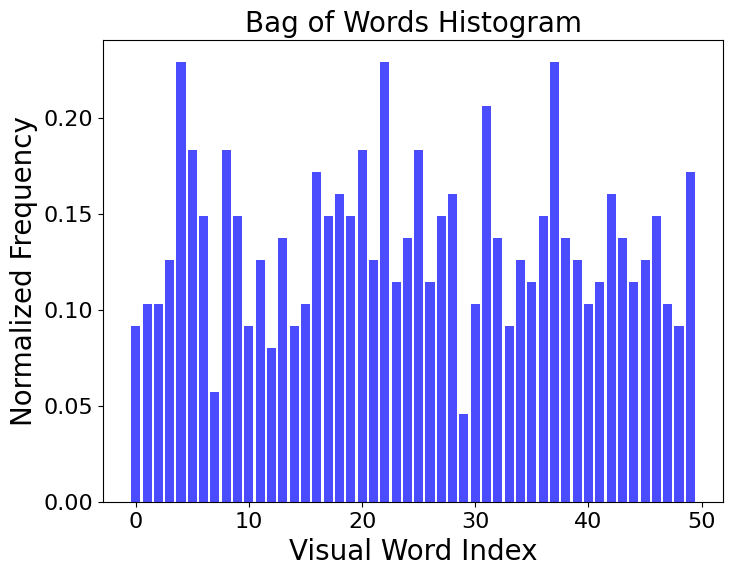

In [49]:
from sklearn.cluster import KMeans

def bag_of_words(descriptors, num_clusters=50):
    """
    Simplified implementation of the Bag of Words (BoW) model.
    Groups descriptors into visual words and computes a histogram.

    Args:
        descriptors (list): List of feature descriptors.
        num_clusters (int): Number of visual words (clusters).

    Returns:
        histogram (numpy.ndarray): Histogram of visual words.
        kmeans (KMeans): Trained KMeans model.
    """
    # Convert descriptors list to a numpy array
    descriptors = np.array(descriptors)

    # Apply KMeans clustering to group descriptors into visual words
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(descriptors)

    # Build histogram of visual words
    histogram, _ = np.histogram(labels, bins=num_clusters, range=(0, num_clusters))
    histogram = histogram / np.linalg.norm(histogram)  # Normalize

    return histogram, kmeans

# Compute Bag of Words representation
bow_histogram, kmeans_model = bag_of_words(sift_descriptors, num_clusters=50)

# Visualize the histogram of visual words
plt.figure(figsize=(8,6))
plt.bar(range(len(bow_histogram)), bow_histogram, color='blue', alpha=0.7)
plt.title('Bag of Words Histogram',fontsize=20)
plt.xlabel('Visual Word Index', fontsize=20)
plt.ylabel('Normalized Frequency', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.show()

## **Histogram of Oriented Gradients (HoG)**

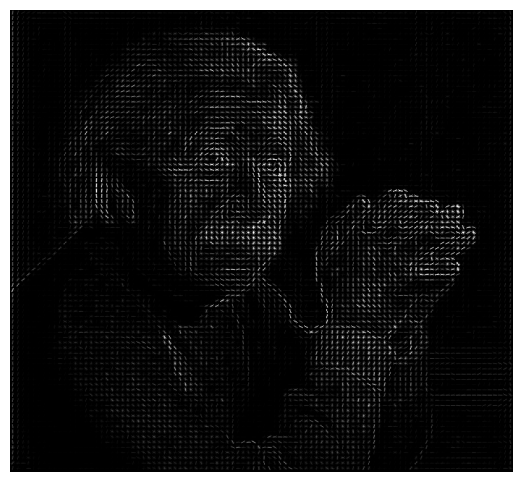

Number of HOG features: 297540


In [50]:
import numpy as np
import matplotlib.pyplot as plt

def compute_hog(image, cell_size=8, block_size=2, bins=9):
    """
    Computes the Histogram of Oriented Gradients (HOG) for a grayscale image.

    Args:
        image (numpy.ndarray): Grayscale image.
        cell_size (int): Size of the cells for computing gradients.
        block_size (int): Size of the block (in cells) for normalization.
        bins (int): Number of orientation bins for the histogram.

    Returns:
        hog_descriptor (numpy.ndarray): Flattened HOG feature descriptor.
    """
    height, width = image.shape
    gradient_x = np.zeros_like(image)
    gradient_y = np.zeros_like(image)

    # Compute gradients
    gradient_x[:, 1:-1] = image[:, 2:] - image[:, :-2]
    gradient_y[1:-1, :] = image[2:, :] - image[:-2, :]

    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    orientation = (np.arctan2(gradient_y, gradient_x) * (180 / np.pi)) % 180  # 0 to 180 degrees

    # Compute HOG for each cell
    num_cells_x = width // cell_size
    num_cells_y = height // cell_size
    histograms = np.zeros((num_cells_y, num_cells_x, bins))

    for i in range(num_cells_y):
        for j in range(num_cells_x):
            cell_magnitude = magnitude[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            cell_orientation = orientation[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]

            # Compute histogram of gradients within the cell
            hist, _ = np.histogram(cell_orientation, bins=bins, range=(0, 180),
                                   weights=cell_magnitude)
            histograms[i, j, :] = hist

    # Normalize histograms over blocks
    block_hog = []
    for i in range(num_cells_y - block_size + 1):
        for j in range(num_cells_x - block_size + 1):
            block = histograms[i:i + block_size, j:j + block_size, :].ravel()
            block = block / np.sqrt(np.sum(block**2) + 1e-6)  # Normalize with small epsilon
            block_hog.append(block)

    return np.hstack(block_hog)

# Example usage with the grayscale image
hog_features, hog_image = computes_hog(gray_image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              block_norm='L2-Hys',
                              visualize=True,
                              feature_vector=True)

# Increase intensity for better visibility
hog_image_intensified = hog_image * 18 # Adjust the scaling factor as needed
hog_image_intensified = hog_image_intensified.clip(0, 1)  # Ensure values stay between 0 and 1

# Plot a subset of the HOG features (e.g., first 100 features)
plt.figure(figsize=(8, 6))
plt.imshow(hog_image_intensified, cmap='gray')
#plt.title("HOG Visualization")
plt.axis("off")
plt.show()

print(f"Number of HOG features: {hog_features.shape[0]}")

# **Question-02**

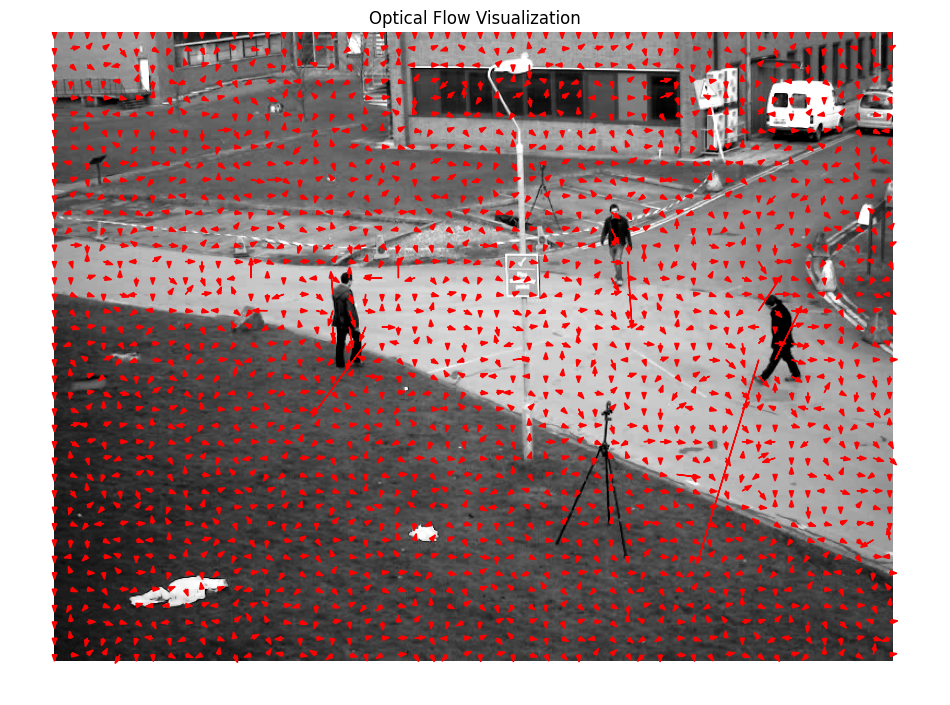

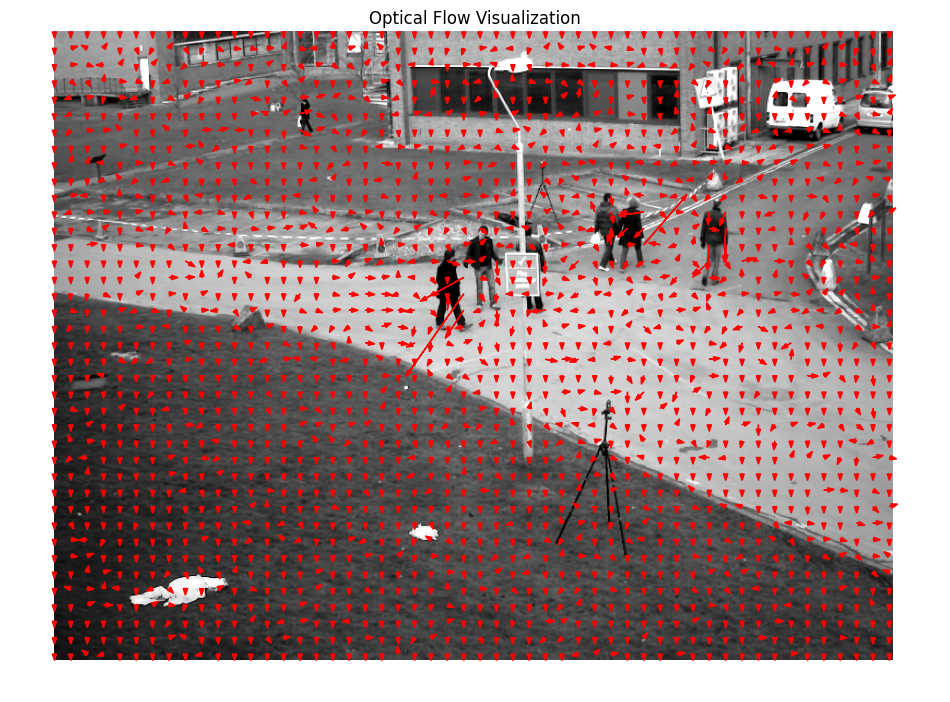

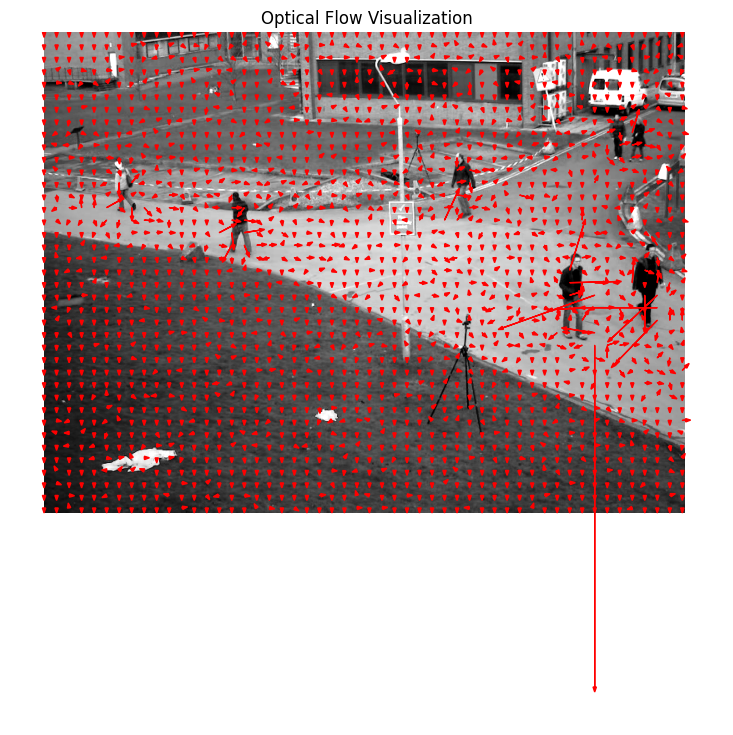

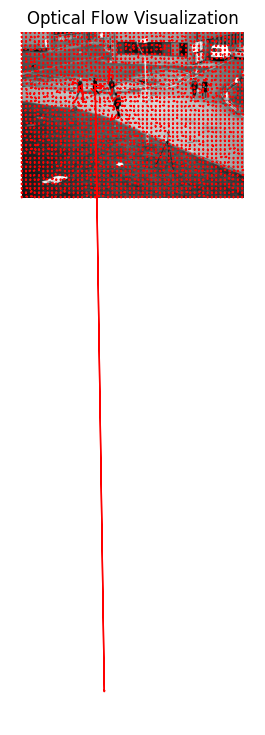

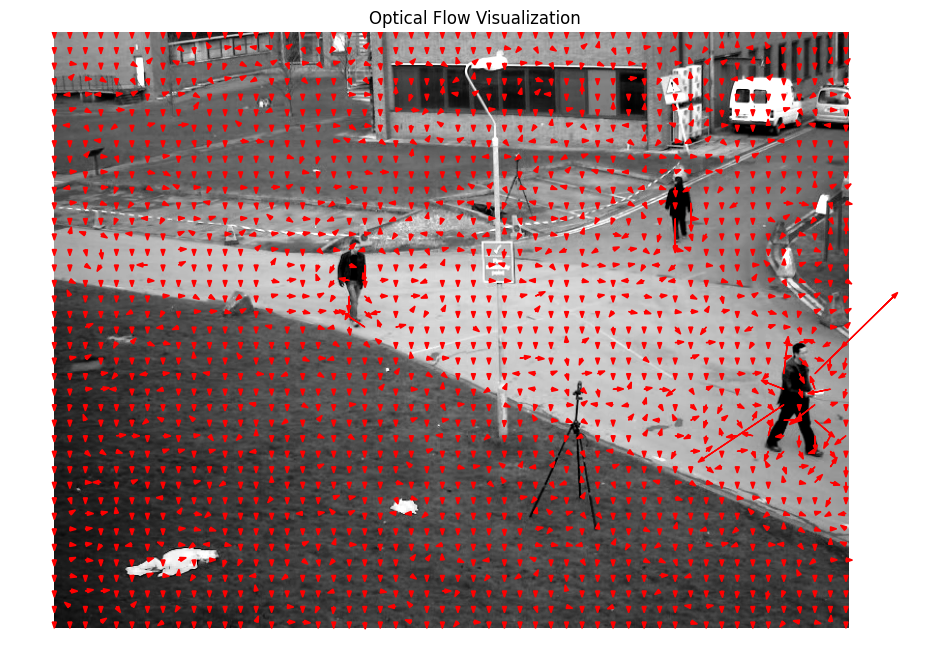

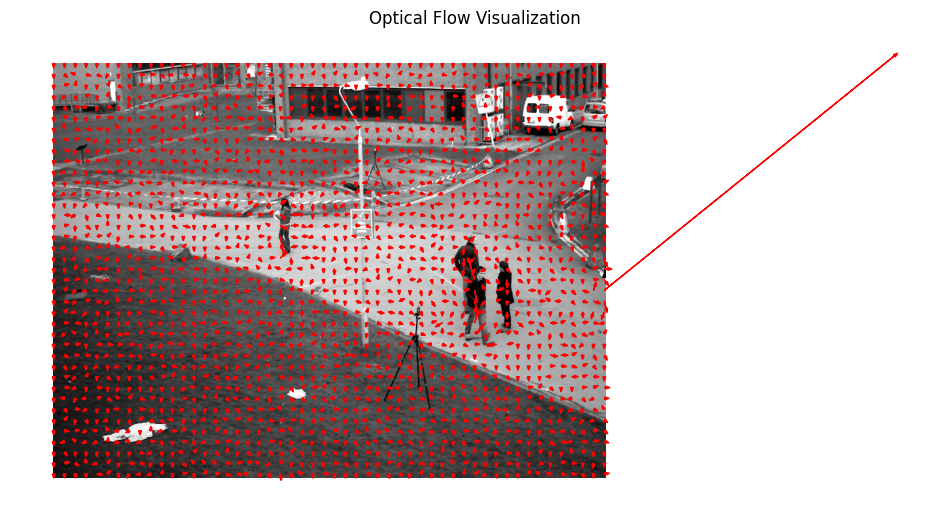

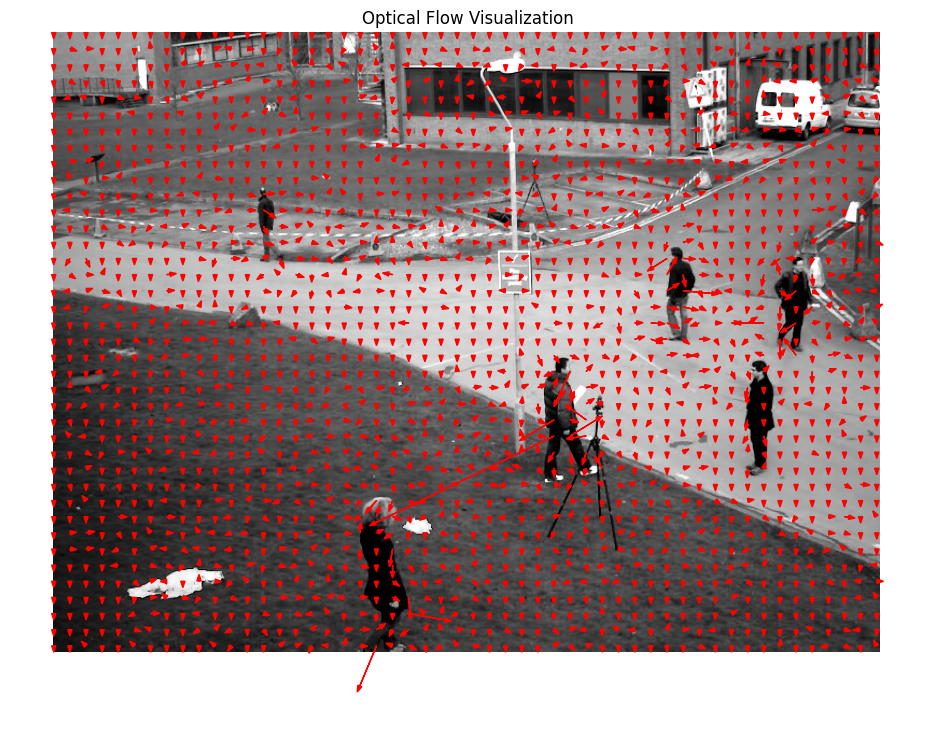

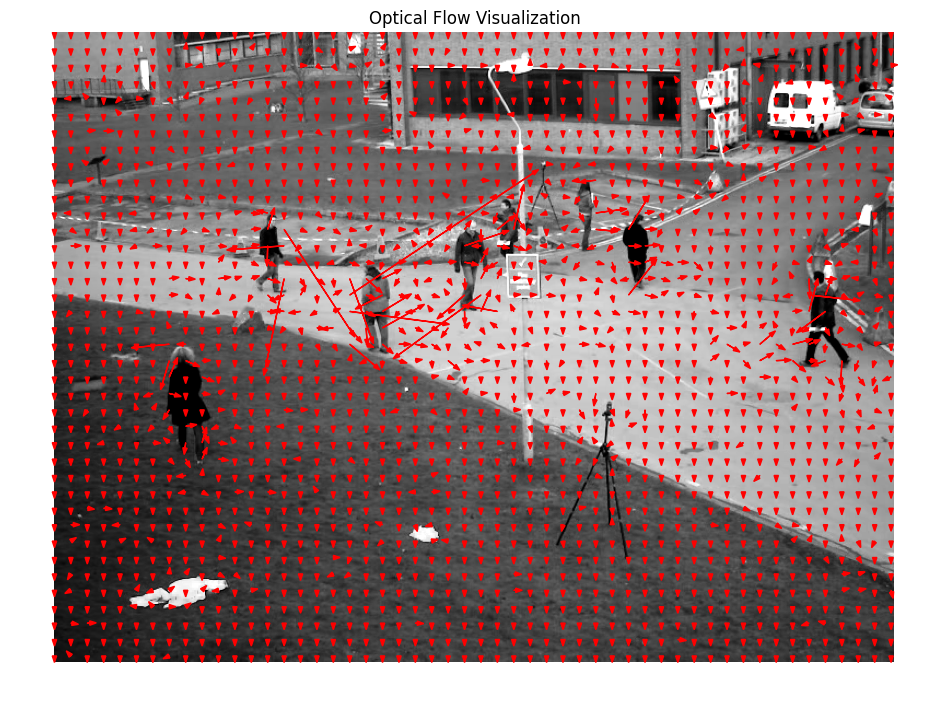

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

def compute_gradients(prev_frame, curr_frame):
    """Compute spatial (Ix, Iy) and temporal (It) gradients."""
    kernel_x = np.array([[-1, 1], [-1, 1]]) * 0.25
    kernel_y = np.array([[-1, -1], [1, 1]]) * 0.25

    Ix = np.zeros_like(prev_frame)
    Iy = np.zeros_like(prev_frame)
    It = curr_frame - prev_frame

    Ix[:-1, :-1] = (prev_frame[:-1, 1:] - prev_frame[:-1, :-1]) * kernel_x[0, 0]
    Iy[:-1, :-1] = (prev_frame[1:, :-1] - prev_frame[:-1, :-1]) * kernel_y[0, 0]

    return Ix, Iy, It

def lucas_kanade_optical_flow(Ix, Iy, It, window_size=5):
    """Compute optical flow using Lucas-Kanade method."""
    w = window_size // 2
    flow = np.zeros((Ix.shape[0], Ix.shape[1], 2))

    for y in range(w, Ix.shape[0] - w):
        for x in range(w, Ix.shape[1] - w):
            Ix_window = Ix[y - w:y + w + 1, x - w:x + w + 1].flatten()
            Iy_window = Iy[y - w:y + w + 1, x - w:x + w + 1].flatten()
            It_window = It[y - w:y + w + 1, x - w:x + w + 1].flatten()

            A = np.stack((Ix_window, Iy_window), axis=1)
            b = -It_window

            if np.linalg.cond(A.T @ A) < 1e-2:
                continue

            v = np.linalg.lstsq(A, b, rcond=None)[0]
            flow[y, x] = v

    return flow

def visualize_optical_flow(prev_frame, flow, step=10, figsize=(10, 8)):
    """Visualize optical flow vectors over the frame."""
    plt.figure(figsize=figsize)
    plt.imshow(prev_frame, cmap='gray')
    for y in range(0, flow.shape[0], step):
        for x in range(0, flow.shape[1], step):
            dx, dy = flow[y, x]
            plt.arrow(x, y, dx, dy, color='red', head_width=4, head_length=6)
    plt.title('Optical Flow Visualization')
    plt.axis('off')
    plt.show()

# Load video frames using imageio.get_reader
video_path = 'vtest.avi'
reader = imageio.get_reader(video_path, 'ffmpeg')

frames = []
for frame in reader:
    # Convert to grayscale
    gray_frame = np.mean(frame, axis=2).astype(np.float32)
    frames.append(gray_frame)

# Determine frame rate (FPS) of the video
fps = reader.get_meta_data()['fps']

# Optical flow computation: one visualization per second
for i in range(0, len(frames) - 1, int(fps)*10):
    prev_frame = frames[i]
    curr_frame = frames[i + 1]

    Ix, Iy, It = compute_gradients(prev_frame, curr_frame)
    flow = lucas_kanade_optical_flow(Ix, Iy, It)
    visualize_optical_flow(prev_frame, flow, step=15, figsize=(12, 9))
